### 下载数据


In [2]:
from mxnet import gluon

root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/')
data_dir = 'data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

# for k, v in dataset.items():
    # gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)

### 读取数据集
我们使用image.ImageDetIter来读取数据。这是针对物体检测的迭代器，(Det表示Detection)。它跟image.ImageIter使用很类似。主要不同是它返回的标号不是单个图片标号，而是每个图片里所有物体的标号，以及其对用的边框。

In [3]:
from mxnet import image
from mxnet import nd

data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)

我们读取一个批量。可以看到标号的形状是batch_size x num_object_per_image x 5。这里数据里每个图片里面只有一个标号。每个标号由长为5的数组表示，第一个元素是其对用物体的标号，其中-1表示非法物体，仅做填充使用。后面4个元素表示边框。

In [4]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


### 图示数据
我们画出几张图片和其对应的标号。可以看到比卡丘的角度大小位置在每张图图片都不一样。不过也注意到这个数据集是直接将二次元动漫皮卡丘跟三次元背景相结合。可能通过简单判断区域的色彩直方图就可以有效的区别是不是有我们要的物体。我们用这个简单数据集来演示SSD是如何工作的。实际中遇到的数据集通常会复杂很多。

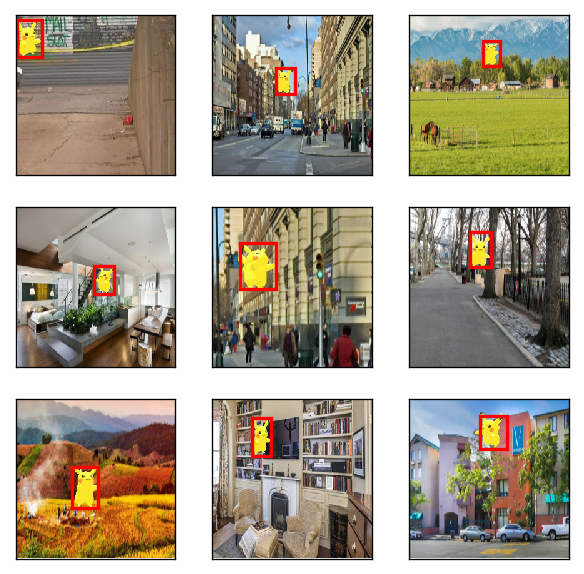

In [5]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()


### 锚框：默认的边界框
因为边框可以出现在图片中的任何位置，并且可以有任意大小。为了简化计算，SSD跟Faster R-CNN一样使用一些默认的边界框，或者称之为锚框（anchor box），做为搜索起点。具体来说，对输入的每个像素，以其为中心采样数个有不同形状和不同比例的边界框。假设输入大小是 w×h，

给定大小 s∈(0,1]，那么生成的边界框形状是 ws×hs
给定比例 r>0，那么生成的边界框形状是 wr√×hr√
在采样的时候我们提供 n 个大小（sizes）和 m 个比例（ratios）。为了计算简单这里不生成nm个锚框，而是n+m−1个。其中第 i 个锚框使用

sizes[i]和ratios[0] 如果 i≤n
sizes[0]和ratios[i-n] 如果 i>n
我们可以使用contribe.ndarray里的MultiBoxPrior来采样锚框。这里锚框通过左下角和右上角两个点来确定，而且被标准化成了区间[0,1]的实数。

In [6]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

# shape: batch x channel x height x weight
n = 40
x = nd.random.uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5,.25,.1], ratios=[1,2,.5])  # 三种size,三种比例

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
# The first anchor box centered on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :]

(40, 40, 5, 4)



[ 0.26249999  0.26249999  0.76249999  0.76249999]
<NDArray 4 @cpu(0)>

我们可以画出以(20,20)为中心的所有锚框：

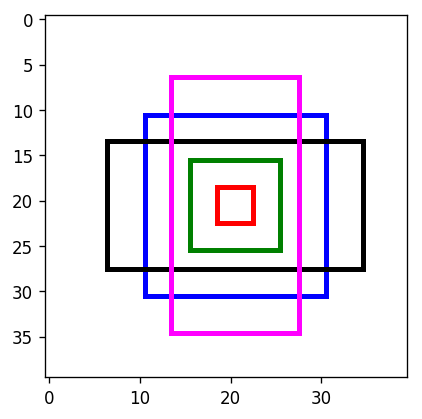

In [8]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

## 预测物体类别
对每一个锚框我们需要预测它是不是包含了我们感兴趣的物体，还是只是背景。这里我们使用一个3×3的卷积层来做预测，加上pad=1使用它的输出和输入一样。同时输出的通道数是num_anchors*(num_classes+1)，每个通道对应一个锚框对某个类的置信度。假设输出是Y，那么对应输入中第n个样本的第(i,j)像素的置信值是在Y[n,:,i,j]里。具体来说，对于以(i,j)为中心的第a个锚框，

### 通道 a*(num_class+1) 是其只包含背景的分数
### 通道 a*(num_class+1)+1+b 是其包含第b个物体的分数
### 我们定义个一个这样的类别分类器函数：

In [9]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = cls_pred(x)
y.shape

(2, 55, 20, 20)

### 预测边界框
因为真实的边界框可以是任意形状，我们需要预测如何从一个锚框变换成真正的边界框。这个变换可以由一个长为4的向量来描述。同上一样，我们用一个有num_anchors * 4通道的卷积。假设输出是Y，那么对应输入中第 n 个样本的第 (i,j) 像素为中心的锚框的转换在Y[n,:,i,j]里。具体来说，对于第a个锚框，它的变换在a*4到a*4+3通道里。

In [10]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2, 40, 20, 20)

### 减半模块
我们定义一个卷积块，它将输入特征的长宽减半，以此来获取多尺度的预测。它由两个Conv-BatchNorm-Relu组成，我们使用填充为10的3×3卷积使得输入和输出有同样的长宽，然后再通过跨度为2的最大池化层将长宽减半。

In [12]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1)) # 卷积层
        out.add(nn.BatchNorm(in_channels=num_filters))           # BN层，批量规范化
        out.add(nn.Activation('relu'))                           # 激活层
        
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 10, 10))
y = blk(x)
y.shape

(2, 10, 5, 5)

### 合并来自不同层的预测输出
前面我们提到过SSD的一个重要性质是它会在多个层同时做预测。每个层由于长宽和锚框选择不一样，导致输出的数据形状会不一样。这里我们用物体类别预测作为样例，边框预测是类似的。

我们首先创建一个特定大小的输入，然后对它输出类别预测。然后对输入减半，再输出类别预测。

In [13]:
x = nd.zeros((2, 8, 20, 20))
print('x:', x.shape)

cls_pred1 = class_predictor(5, 10)     # 类别分类器函数
cls_pred1.initialize()
y1 = cls_pred1(x)
print('Class prediction 1:', y1.shape)

ds = down_sample(16)                   # 减半模块
ds.initialize()
x = ds(x)
print('x:', x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print('Class prediction 2:', y2.shape)

x: (2, 8, 20, 20)
Class prediction 1: (2, 55, 20, 20)
x: (2, 16, 10, 10)
Class prediction 2: (2, 33, 10, 10)


可以看到y1和y2形状不同。为了之后处理简单，我们将不同层的输入合并成一个输出。首先我们将通道移到最后的维度，然后将其展成2D数组。因为第一个维度是样本个数，所以不同输出之间是不变，我们可以将所有输出在第二个维度上拼接起来。